Nice read on "How to set up Anaconda and Jupyter Notebook the right way": https://towardsdatascience.com/how-to-set-up-anaconda-and-jupyter-notebook-the-right-way-de3b7623ea4a

In [1]:
import json
import pandas as pd
import gzip

# Familiarize Yourself with the Dataset
In the lab sessions, we will work with the "All Beauty" category of the Amazon Review Data, and we will use the 5-core subset. You can download the dataset and find information about it here: https://nijianmo.github.io/amazon/index.html

## Exercise 1
Download and import the 5-core dataset.

In [2]:
# def parse(path):
#     g = gzip.open(path, 'rb')
#     for l in g:
#         yield json.loads(l)

# def getDF(path):
#     i = 0
#     df = {}
#     for d in parse(path):
#         df[i] = d
#         i += 1
#     return pd.DataFrame.from_dict(df, orient='index')

# df = getDF('All_Beauty_5.json')

# If you unzip the folder manually, you may simply run the following command:
df = pd.read_json("All_Beauty_5.json", lines=True)

## Exercise 2

### 2.1
Sort the dataset entries (ascending) by user id (`reviewerID`), product id (`asin`) and rating timestamp (`unixReviewTime`). Then, check the dataset for missing ratings (`overall`) and duplicates (cases where the same user has rated the same item multiple times) and clean them, if any. For duplicates, keep the last entry only. How many observations does the cleaned dataset have?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5269 entries, 0 to 5268
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         5269 non-null   int64 
 1   verified        5269 non-null   bool  
 2   reviewTime      5269 non-null   object
 3   reviewerID      5269 non-null   object
 4   asin            5269 non-null   object
 5   style           4624 non-null   object
 6   reviewerName    5269 non-null   object
 7   reviewText      5264 non-null   object
 8   summary         5264 non-null   object
 9   unixReviewTime  5269 non-null   int64 
 10  vote            552 non-null    object
 11  image           98 non-null     object
dtypes: bool(1), int64(2), object(9)
memory usage: 458.1+ KB


In [4]:
# the number of samples that have non-defined value for the overall property
df.overall.isna().sum()

0

In [5]:
def data_cleaning(df):
    df_cleaned = df.sort_values(["reviewerID", "asin", "unixReviewTime"],ascending=[True,True, True])
    df_cleaned = df_cleaned[df_cleaned.overall.notna()]
    df_cleaned = df_cleaned.drop_duplicates(keep="last", subset=["reviewerID", "asin"])
    return df_cleaned

df = data_cleaning(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4092 entries, 737 to 3848
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         4092 non-null   int64 
 1   verified        4092 non-null   bool  
 2   reviewTime      4092 non-null   object
 3   reviewerID      4092 non-null   object
 4   asin            4092 non-null   object
 5   style           3483 non-null   object
 6   reviewerName    4092 non-null   object
 7   reviewText      4088 non-null   object
 8   summary         4088 non-null   object
 9   unixReviewTime  4092 non-null   int64 
 10  vote            408 non-null    object
 11  image           74 non-null     object
dtypes: bool(1), int64(2), object(9)
memory usage: 387.6+ KB


### 2.2
Create a test set by extracting the *single* **latest** (based on the timestamp `unixReviewTime`) positively rated item (rating $\geq 4$) by each user. Remove users that do not appear in the training set. How many observations does the training and test set have?

Note: After the test set is extracted, the *cleaned* dataset is now the trainset. (i.e., the trainset is completely separate from the test set, not a superset of it)

In [7]:
def data_split(df):
    df_positive = df[df['overall']>=4]

    # For each user get his latest review
    test = df_positive \
        .sort_values(["reviewerID","unixReviewTime"],ascending=[True,True]) \
        .drop_duplicates(keep="last", subset=["reviewerID"])

    test_sample_indeces = test.index.to_list()

    # drop all rows that are in the test set
    training = df.drop(test_sample_indeces)

    # drop all users that aren't in the training set
    test = test[test.reviewerID.isin(training.reviewerID.to_list())]

    return training, test

In [8]:
df_train, df_test = data_split(df)

print("Observations in training set:", len(df_train))
print("Observations in test set:", len(df_test))

Observations in training set: 3133
Observations in test set: 949


## Exercise 3

Compute the number of ratings per item in the training set. How does a barplot of the number of ratings per item ordered by decreasing frequency look like?

Reflect on how it will affect the prediction process of a recommender system if only a small fraction of the items are rated frequently.

In [9]:
df_per_item_review_count = df_train.groupby("asin", as_index=False).size()

In [10]:
df_per_item_review_count["size"]

0       4
1     489
2       3
3       1
4       2
5     386
6     386
7      15
8       2
9      11
10      3
11     15
12      4
13    849
14      4
15      4
16      1
17      1
18      1
19      1
20      1
21     26
22      1
23      1
24      1
25      1
26    530
27     16
28      1
29      4
30      6
31     13
32      3
33     33
34    131
35      1
36      7
37      2
38      2
39      1
40      2
41      5
42      1
43      5
44     14
45      6
46     13
47      1
48     11
49      9
50      2
51      1
52     35
53      8
54     11
55     23
56      1
57     11
58     11
Name: size, dtype: int64

In [11]:
df_per_item_review_count.size

118

In [12]:
df_per_item_review_count.iloc[:,1].shape

(59,)

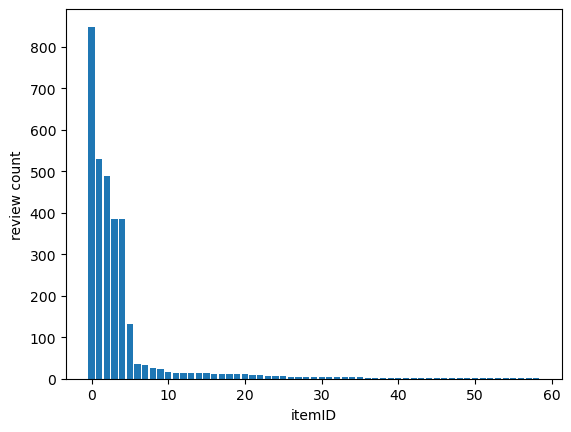

In [13]:
import matplotlib.pyplot as plt

df_per_item_review_count = df_train.groupby("asin", as_index=False).size().sort_values(["size"], ascending=[False])
plt.bar(x=range(df_per_item_review_count.shape[0]), height=df_per_item_review_count.iloc[:,1])
plt.xlabel("itemID")
plt.ylabel("review count")
plt.show()

# Collaborative Filtering Recommender System

## Exercise 1
In this exercise, we are going to predict the rating of a single user-item pair using a neighborhood-based method.

### 1.1
- Represent the ratings from the training set in a user-item matrix where the rows represent users and the columns represent items.
- Fill unobserved ratings with $0$.
- Compute the cosine similarities between the user with `reviewerID`='A25C2M3QF9G7OQ' and all users that have rated the item with `asin`='B00EYZY6LQ'.
- What are the similarities and what are the ratings given by these users on item 'B00EYZY6LQ'?

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [15]:
# Loading and preparing data
user_item_matrix = df_train.pivot_table(index='reviewerID',columns='asin',values='overall')
user_item_matrix = user_item_matrix.fillna(0)
target_user = user_item_matrix.loc[['A25C2M3QF9G7OQ']]
input_users = user_item_matrix[user_item_matrix['B00EYZY6LQ']>0]
users = pd.concat([target_user, input_users])

# Write your code here to compute cosine similarity and report results

similarities = cosine_similarity(input_users, target_user)
target_item = input_users['B00EYZY6LQ'].to_frame('B00EYZY6LQ')
target_item["cosine similarity"] = similarities
target_item


,B00EYZY6LQ,cosine similarity
reviewerID,,
A1F7YU6O5RU432,5.0,0.079243
A1R1BFJCMWX0Y3,3.0,0.245145
A1UQBFCERIP7VJ,5.0,0.058634
A22CW0ZHY3NJH8,3.0,0.207883
A2LW5AL0KQ9P1M,4.0,0.275810
A2PD27UKAD3Q00,5.0,0.000000
A2WW57XX2UVLM6,4.0,0.000000
A2ZY49IDE6TY5I,4.0,0.682835
A39WWMBA0299ZF,5.0,0.000000


### 1.2
Predict the rating for user 'A25C2M3QF9G7OQ' on item 'B00EYZY6LQ' based on the ratings from the $5$ most similar users, using a weighted (by cosine similarity) average. You do not need to account for the mean rating per user for the weighted average. What is the prediction? Round the predicted rating to 3 decimal places.

In [16]:
k = 5
target_item_k = target_item.sort_values(by="cosine similarity", ascending=False)[:k]


In [17]:
prediction_KNN = (target_item_k['B00EYZY6LQ'] * target_item_k['cosine similarity']).sum() / target_item_k['cosine similarity'].sum()

print('Predicted rating:', prediction_KNN)

Predicted rating: 3.8745289248148613


In [18]:
### Recommended: Save the dataframe to load them in the next Session

df_train.to_pickle("train_dataframe.pkl")
df_test.to_pickle("test_dataframe.pkl")